---
title: "Kinematic Analysis"
author: "Ali Zaidi"
date: "2025-11-15"
image: null
categories: [Data Visualization]
description: "Now that we have our labeled clips, lets run some preliminary analysis over each of their keypoints and see what we can extract"
format:
  html:
    code-fold: true
jupyter: python3
---

In [52]:
#| include: false
from fastai.vision.all import *
from swing_data import *
from itertools import chain
from lower_body import *
from upper_body import *
from utils import *

In [2]:
#| include: false
plt.style.use('dark_background')
#plt.style.use('default')

In [63]:
#| include: false
base_path = '../../../data/full_videos/ymirza'
swing_days = ['jun8', 'aug9', 'sep14']
parent_dir = f'{base_path}/{swing_days[-1]}'
files = [file for file in get_files(parent_dir, extensions='.pkl') if file.name[:3] == 'IMG']
files_names = [file.name.split('.')[0] for file in files]
#print(f'We have the following original videos: \n\
#{files_names} \nin this set of swings')

In [65]:
#| code-fold: true
#| echo: false
kp_folder_paths_dict = {files_names[x]: files[x] for x in range(len(files))}
print(f'We have {len(kp_folder_paths_dict)} total swings from {swing_days[-1]}')

We have 47 total swings from sep14


In [66]:
#| include: false
flat_kp_file_list = kp_folder_paths_dict.values()
len(flat_kp_file_list)

47

In [67]:
#| code-fold: true
def get_kps(folder):
    all_files = get_files(folder, extensions='.pkl')
    clip_files = [file for file in all_files if file.name[:3] == 'IMG']
    return clip_files


def flatten_stacked_list(nonflat_list):
    flattened_list = list(chain.from_iterable(nonflat_list))
    return flattened_list


def get_all_swings_df(flat_kp_path_list):
    path_list_series =  pd.Series(flat_kp_path_list)
    kp_fname = path_list_series.map(lambda x: str(x).split('/')[-1])
    video_name = kp_fname.map(lambda x: '_'.join(str(x).split('_')[:2]))
    swing_idx = kp_fname.map(lambda x: str(x).split('_')[3])
    df = pd.DataFrame([video_name, swing_idx, 
                       kp_fname, path_list_series],
                      index=['video_name','swing_idx', 
                             'kp_fname', 'kp_fpath']
                      ).T
    return df

In [37]:
#| code-fold: true
all_swings_df = get_all_swings_df(flat_kp_file_list)
all_swings_df.head(3)

,video_name,swing_idx,kp_fname,kp_fpath
0,IMG_1093,6,IMG_1093_swing_6_score_None.pkl,../../../data/full_videos/ymirza/sep14/IMG_1093/keypoints/IMG_1093_swing_6_score_None.pkl
1,IMG_1093,5,IMG_1093_swing_5_score_None.pkl,../../../data/full_videos/ymirza/sep14/IMG_1093/keypoints/IMG_1093_swing_5_score_None.pkl
2,IMG_1093,4,IMG_1093_swing_4_score_None.pkl,../../../data/full_videos/ymirza/sep14/IMG_1093/keypoints/IMG_1093_swing_4_score_None.pkl


In [38]:
#| code-fold: true
### 99 —> prctice swing w/o score
sep14_scores = {
    "IMG_1086" : [2, 1, 1, 5, 5], #5
    "IMG_1087" : [4, 5, 2, 1, 2],# 5
    "IMG_1088" : [1, 1, 3, 3, 2],# 5
    "IMG_1089" : [4, 3, 3, 4, 3, 4, 3], #7
    "IMG_1090" : [4, 1, 4, 1, 1, 1], #6
    "IMG_1091" : [2, 2, 5, 2, 4, 1], 
                #6 - 7 w/practice --> start 30 seconds in
    "IMG_1092" : [4, 1, 4, 1, 1, 1,], # 6
    "IMG_1093" : [1, 3, 1, 2, 1, 99, 2],
    # 6 - 7 w/practice --> just drop second to last clip
    }

In [39]:
#| include: false
def add_scores(swings_df, scores_dict):
    scores = []
    for x in range(len(swings_df)):
        row = swings_df.iloc[x]
        video_name = row.video_name
        swing_idx = row.swing_idx
        all_video_scores = scores_dict[video_name]
        scores.append(all_video_scores[int(swing_idx)])
    swings_df['fname_swing'] = swings_df.kp_fname.map(lambda x: '_'.join(x.split('_')[:5]))
    swings_df['scores'] = scores
    swings_df['plot_name'] = swings_df['fname_swing'] + '_' + swings_df['scores'].map(lambda x: str(x))
    return swings_df

scored_df = add_scores(all_swings_df, sep14_scores)
scored_df.head(3)

,video_name,swing_idx,kp_fname,kp_fpath,fname_swing,scores,plot_name
0,IMG_1093,6,IMG_1093_swing_6_score_None.pkl,../../../data/full_videos/ymirza/sep14/IMG_1093/keypoints/IMG_1093_swing_6_score_None.pkl,IMG_1093_swing_6_score,2,IMG_1093_swing_6_score_2
1,IMG_1093,5,IMG_1093_swing_5_score_None.pkl,../../../data/full_videos/ymirza/sep14/IMG_1093/keypoints/IMG_1093_swing_5_score_None.pkl,IMG_1093_swing_5_score,99,IMG_1093_swing_5_score_99
2,IMG_1093,4,IMG_1093_swing_4_score_None.pkl,../../../data/full_videos/ymirza/sep14/IMG_1093/keypoints/IMG_1093_swing_4_score_None.pkl,IMG_1093_swing_4_score,1,IMG_1093_swing_4_score_1


In [40]:
#| include: false

def add_kps(swings_df):
    swings_df['kps'] = swings_df.kp_fpath.map(lambda x: KpExtractor(x).kps )
    return swings_df

final_df = add_kps(scored_df)
final_df.kps[0].shape

(180, 17, 3)

### There are two instances of practice swings without hitting the ball and without a score, they are marked below, 
#### IMG_1091 there is a practice swing at start of video
    - Easily taken care of by starting the autodetect function 30 seconds into the video -- no longer accounted for in the 47 total
#### IMG_1093 there is a practice swing on the second to last swing
    - this doesn't interfere with autodetect finding last swting, so we can just ignore that second to last swing in our anaylsis (swing_idx 5)
    - therefore only 46 swings

### This could maybe be easily tackled by also checking for a score hand (right hand up left hand below shoulder and then checking backwards towards a swing, if there's no swing in between that next hand and this swing, you know this is not a practice swing)


In [80]:
list(range(1,6,1))

[1, 2, 3, 4]

In [90]:
#| echo: false
print('Most of the swings on this day were scored 1')
print(final_df.scores.value_counts())

Most of the swings on this day were scored 1
scores
1     17
2      9
4      9
3      7
5      4
99     1
Name: count, dtype: int64


In [42]:
#| include: false
five_idxs = np.where(final_df.scores == 5)[0]
one_idxs = np.where(final_df.scores == 1)[0]
one_five_idxs = flatten_stacked_list([five_idxs[:3], one_idxs[:3]])
one_five_idxs

[7, 11, 27, 2, 4, 5]

In [55]:
#| include: false
test_df = final_df.iloc[one_five_idxs].reset_index(drop=True)
test_kps = test_df.kps
plot_lbls = test_df.plot_name
test_df.shape

(6, 8)

In [56]:
#| code-fold: true
top_idxs = [get_frame_plot(x[30:])[0] + 30 for x in test_kps]
lowest_frame_count = np.array([kp.shape[0] for kp in test_kps]).min()
highest_peak_frame = np.array(top_idxs).max()
diff = lowest_frame_count - highest_peak_frame
start_idx = highest_peak_frame - diff
end_idx = highest_peak_frame + diff
print(f'The frame index where the straight arm is found \
in the backswing are: {top_idxs}')
print(f'The highest peak frame where this is found is: {highest_peak_frame}')
print(f'The lowest frame count in any of our clips is: {lowest_frame_count}')
print(f'We have a difference of {diff} frames between where this happens')
print(f'The indexes we will use to index all these videos are:\n \
start:{start_idx} and end:{end_idx}')

The frame index where the straight arm is found in the backswing are: [131, 138, 136, 133, 136, 141]
The highest peak frame where this is found is: 141
The lowest frame count in any of our clips is: 180
We have a difference of 39 frames between where this happens
The indexes we will use to index all these videos are:
 start:102 and end:180


In [57]:
#| include: false
idx_bounds = [(top_idxs[x]-40, top_idxs[x] + 40)for x in range(len(test_kps))]
test_kps = [test_kps[x][idx_bounds[x][0]:idx_bounds[x][1]] for x in range(len(idx_bounds))]
[x.shape for x in test_kps]

[(80, 17, 3), (80, 17, 3), (80, 17, 3), (80, 17, 3), (80, 17, 3), (79, 17, 3)]

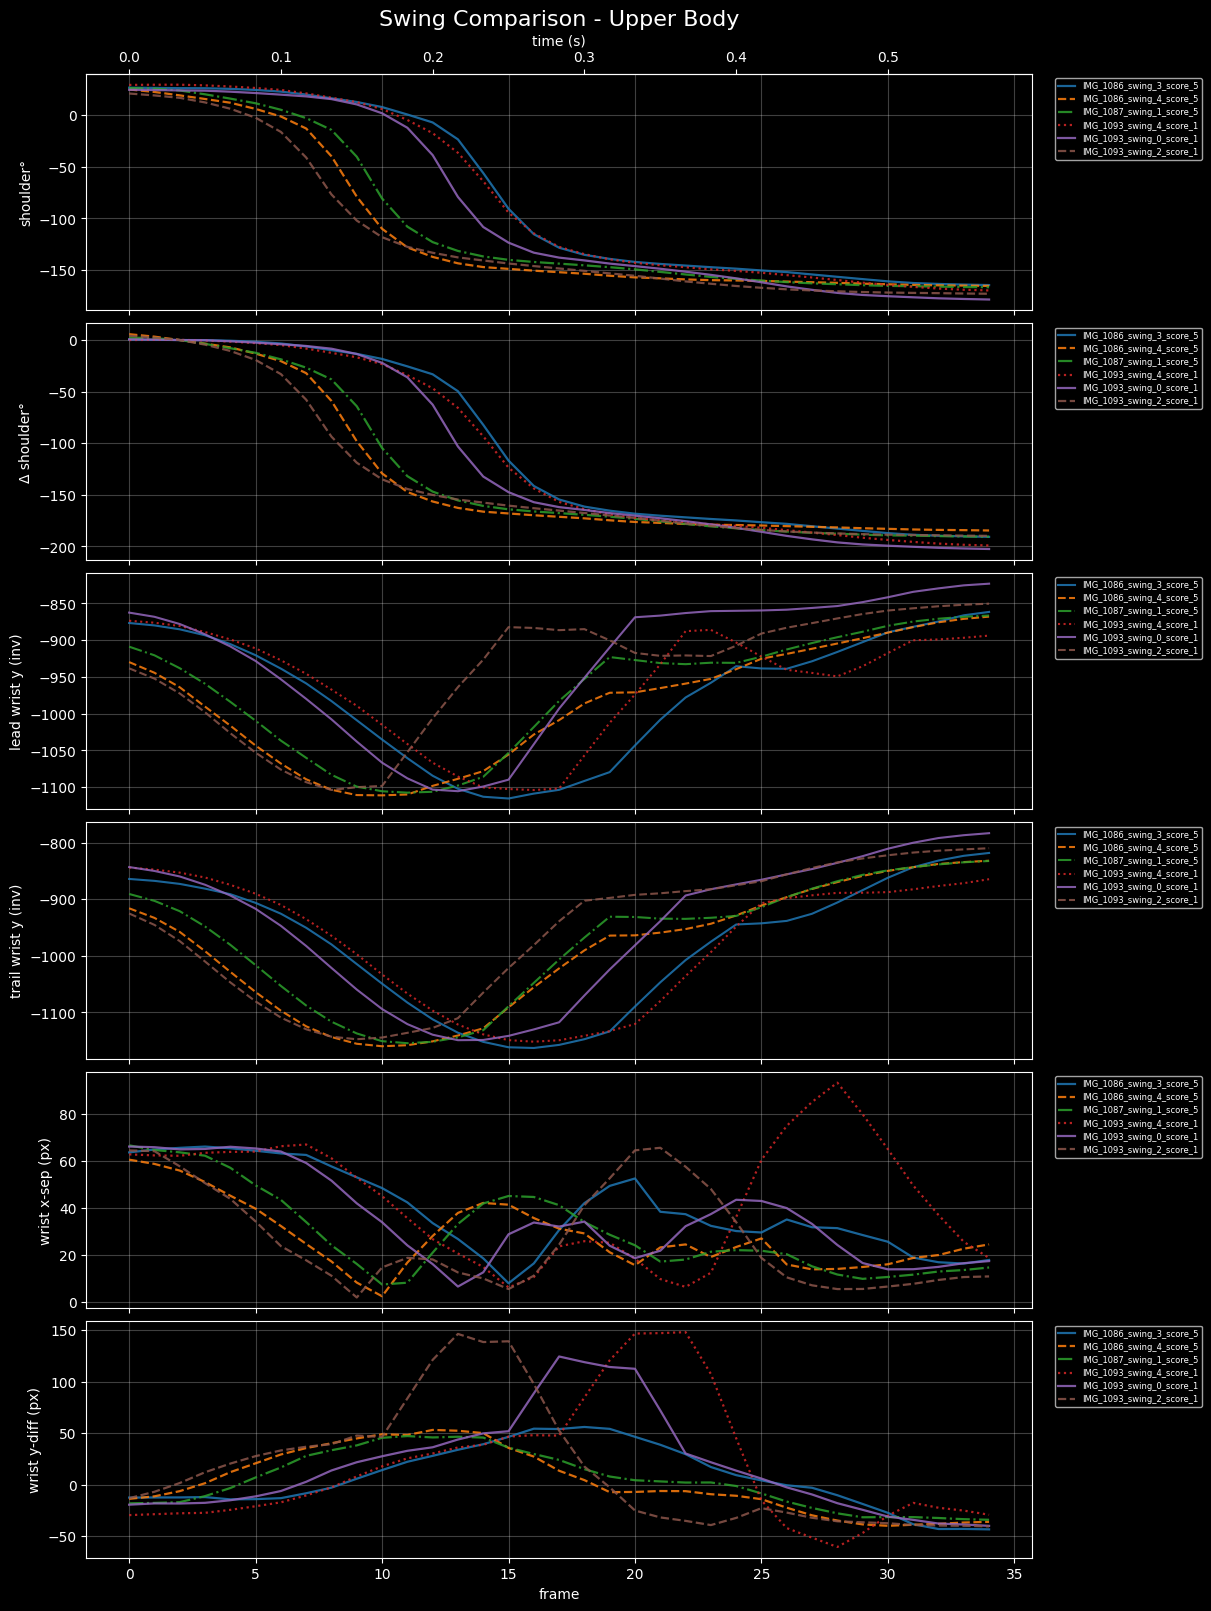

In [60]:
# code-fold:True
fig, axes = plot_upper_body_comparison(
    kps_list=[x[...,:2][10:45] for x in test_kps],
    scores_list=[x[...,2][10:45] for x in test_kps],
    labels=plot_lbls,
    params=UpperPlotParams(handedness="right", smooth_win=5, fps=60.0),
    title="Swing Comparison - Upper Body"
)

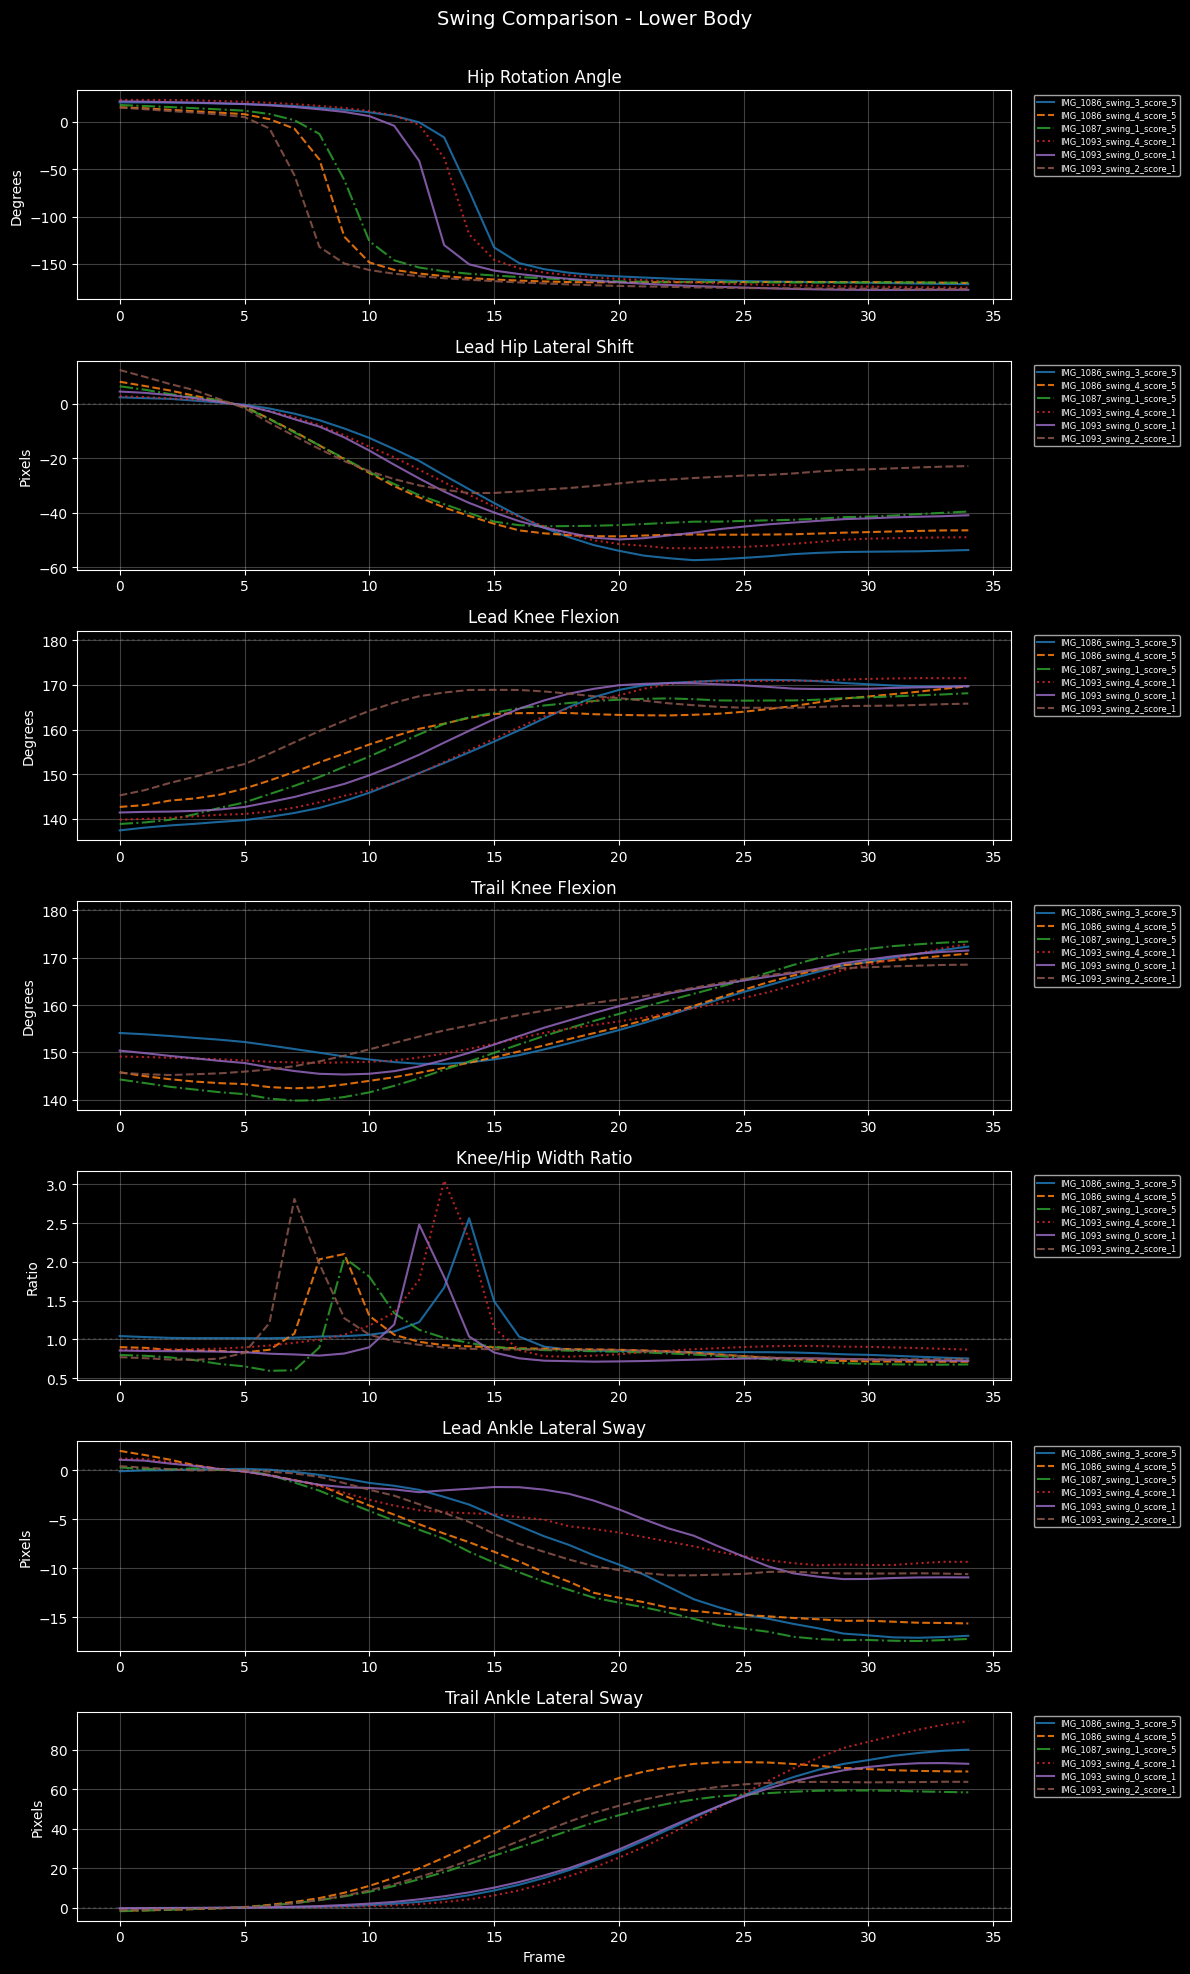

In [61]:
#| code-fold: true
fig, axes = plot_lower_body_detailed(
    kps_list=[x[...,:2][10:45] for x in test_kps],
    scores_list=[x[...,2][10:45] for x in test_kps],
    labels=plot_lbls,
    params=PlotParams(handedness="right", smooth_win=5, fps=60.0),
    title="Swing Comparison - Lower Body"
)